In [1]:
from torchvision.datasets import ImageFolder
import torch.utils.data as Data
import torchvision.transforms as transforms
import  time # 导入模块
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np

In [2]:
def corr2d(X,K):
    """

    :param X: 输入, shape (H,w)
    :param K: 卷积核, shape (k_h,k_w)
    :return:
    """
    batch_size, H, W = X.shape
    k_h, k_w = K.shape
    # 初始化结果矩阵
    Y = torch.zeros((batch_size, H - k_h + 1, W - k_w + 1)).to(device)
    for i in range(Y.shape[1]):
        for j in range(Y.shape[2]):
            Y[:, i, j] = (X[:, i: i + k_h, j: j + k_w] * K).sum()
    return Y

def corr2d_multi_in(X,K):
    """
    :param X:输入：维度(batch_size, C_in, H, W)
    :param K: 卷积核(C_in, k_h, k_w)
    :return: 维度(batch_size, H_out, W_out)
    """
    res = corr2d(X[:,0,:,:], K[0,:,:])
    for i in range(1, X.shape[1]):
        # 按通道相加
        res += corr2d(X[:,i,:,:], K[i,:,:])
    return res

def corr2d_multi_in_out(X,K):
    """
    :param X: shape (batch_size, C_in, H, W)
    :param K: shape(C_out, C_in, h, w)
    :return: Y: shape (batch_size, C_out, H_out, W_out)
    """
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim = 1)

class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MyConv2D, self).__init__()
        # 初始化卷积层的2个参数：卷积核、偏差
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels, 1, 1))

    def forward(self,x):
        """
        x: 输出图片, 维度(batch_size,C_in, H, W)
        """
        return corr2d_multi_in_out(x, self.weight) + self.bias

class MyConvModule(nn.Module):
    def __init__(self):
        super(MyConvModule, self).__init__()
        # 定义三层卷积
        self.conv = nn.Sequential(
            MyConv2D(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        # 输出层， 将通道数变为分类数量
        self.fc = nn.Linear(32, num_classes)

    def forward(self,X):
        # 图片先经过三层卷积，输出维度(batch_size, C_out, H, W)
        out = self.conv(X)
        print(out.size())
        # 使用平均池化层将图像的大小变为1*1
        out = F.avg_pool2d(out, 80)
        print(out.size())
        out = out.squeeze()
        out = self.fc(out)
        return out

In [3]:
def train_epoch(net, data_loader, device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        print(data.size())
        # print(target)
        
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
#         print("output", output)
#         print("prediction", prediction)
#         print("target", target)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((120,85)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])
BATCH_SIZE = 128
train_dataset = ImageFolder("vehicle_dataset/train_dataset",transform = data_transform)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageFolder("vehicle_dataset/test_dataset",transform = data_transform)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
# print(len(train_dataset))
# print(len(test_dataset))
# print(train_dataset[0][0].size())
# print(train_dataset.class_to_idx)
# print(test_dataset[0][0].size())
# print(test_dataset.class_to_idx)

1017
340
torch.Size([3, 120, 85])
{'bus': 0, 'car': 1, 'truck': 2}
torch.Size([3, 120, 85])
{'bus': 0, 'car': 1, 'truck': 2}


In [ ]:
num_classes = 3
epochs = 20
lr = 0.001
device = torch.device('cpu')
# device = torch.device('cuda')

net = MyConvModule().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
training_time_list = []
for epoch in range(epochs):
    print("开始训练------" + str(epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(net, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")

开始训练------0-------------
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([121, 3, 120, 85])
torch.Size([121, 32, 118, 83])
torch.Size([121, 32, 1, 1])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([84, 32, 118, 83])
torch.Size([84, 32, 1, 1])
epoch:0	 train_loss:1.2105 	train_acc: 0.2655 	test_loss: 0.9940 	 test_acc: 0.5735 	 tr

torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([121, 3, 120, 85])
torch.Size([121, 32, 118, 83])
torch.Size([121, 32, 1, 1])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([84, 32, 118, 83])
torch.Size([84, 32, 1, 1])
epoch:9	 train_loss:0.9716 	train_acc: 0.5742 	test_loss: 1.0436 	 test_acc: 0.5735 	 training_time: 2168.38
开始训练------10-------------
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.Size([128, 32, 1, 1])
torch.Size([128, 3, 120, 85])
torch.Size([128, 32, 118, 83])
torch.

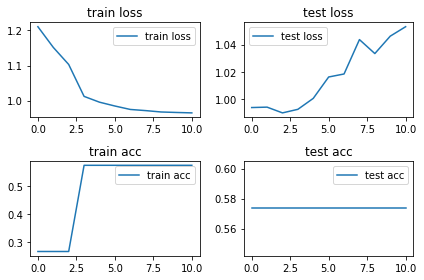

In [4]:
train_loss_list = [1.2105,1.1516,1.1030,1.0121,0.9956,0.9847,0.9749,0.9716,0.9677,0.9663,0.9651]
train_acc_list = [0.2655,0.2655,0.2655,0.5742,0.5742,0.5742,0.5742,0.5742,0.5742,0.5742,0.5742]
test_loss_list = [0.9940, 0.9943,0.9901,0.9927,1.0007,1.0163,1.0185,1.0436,1.0334,1.0461,1.0530]
test_acc_list = [0.5735,0.5735,0.5735,0.5735,0.5735,0.5735,0.5735,0.5735,0.5735,0.5735,0.5735,]
import matplotlib.pyplot as plt
%matplotlib inline
def plot(train_loss_list,label,title, subplot):
    ax1 = plt.subplot(subplot)
    plt.plot(list(range(len(train_loss_list))),train_loss_list, label=label)
    ax1.set_title(title)
    ax1.legend()
#     plt.title(title)
#     plt.legend()
#     plt.show()
plot(train_loss_list,"train loss","train loss", 221)
plot(test_loss_list,"test loss","test loss", 222)
plot(train_acc_list,"train acc","train acc", 223)
plot(test_acc_list,"test acc","test acc", 224)
plt.tight_layout()
plt.show()